In [1]:
import os
import dlib
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
class EyeTrackingDataset(Dataset):
    def __init__(self, image_dir, calibration_points):
        """
        Dataset class for eye tracking.

        Args:
        - image_dir (str): Directory containing all images.
        - calibration_points (list): List of gaze points for calibration.
        """
        self.image_dir = image_dir
        self.samples = []
        self.calibration_points = calibration_points

        # Initialize Dlib face detector and predictor
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

        # Collect all valid image files
        for img_file in sorted(os.listdir(image_dir)):
            if img_file.endswith(".jpg"):
                image_path = os.path.join(image_dir, img_file)
                # Validate face detection
                if self.validate_face(image_path):
                    self.samples.append(image_path)

    def validate_face(self, image_path):
        """
        Validates if a face is detected in the image.

        Args:
        - image_path (str): Path to the image.
        
        Returns:
        - bool: True if a face is detected, False otherwise.
        """
        image = cv2.imread(image_path)
        if image is None:
            return False
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = self.detector(gray)
        return len(faces) > 0

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Extract landmarks and pupil positions for the given image.

        Returns:
        - landmarks (Tensor): Flattened 136-dimensional array (68 landmarks).
        - label (Tensor): Gaze target (x, y) on the screen.
        """
        image_path = self.samples[idx]
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Failed to load image: {image_path}")

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = self.detector(gray)
        if len(faces) == 0:
            raise ValueError(f"No face detected in image: {image_path}")

        landmarks = self.predictor(gray, faces[0])  # Use first detected face
        landmark_coords = np.array([[p.x, p.y] for p in landmarks.parts()], dtype=np.float32).flatten()

        # Simulate a gaze point using calibration points (cyclic assignment)
        label = self.calibration_points[idx % len(self.calibration_points)]

        return torch.tensor(landmark_coords, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

In [3]:
class EyeTrackingModel(nn.Module):
    def __init__(self):
        super(EyeTrackingModel, self).__init__()
        self.fc_landmarks = nn.Sequential(
            nn.Linear(136, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )
        self.fc_combined = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Predict gaze point (x, y)
        )

    def forward(self, landmarks):
        x = self.fc_landmarks(landmarks)
        return self.fc_combined(x)

In [4]:
# Calibration points (screen coordinates for training)
calibration_points = [
    [0.3, 0.3],  # Top-left
    [0.5, 0.3],  # Top-right
    [0.5, 0.8],  # Bottom-left
    [0.8, 0.8]   # Bottom-right
]

# Dataset and DataLoader
image_dir = "Data_3"
dataset = EyeTrackingDataset(image_dir, calibration_points)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

Training samples: 14748, Validation samples: 3688


In [5]:
# Device Configuration
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize Model, Loss, and Optimizer
model = EyeTrackingModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 20
training_losses = []  # Store training losses for plotting
validation_losses = []  # Store validation losses for plotting

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_mae = 0.0  # Initialize Mean Absolute Error accumulator

    for landmarks, label in train_loader:
        landmarks, label = landmarks.to(device), label.to(device)

        optimizer.zero_grad()
        predictions = model(landmarks)

        # Compute Loss
        loss = criterion(predictions, label)
        loss.backward()
        optimizer.step()

        # Update Running Loss
        running_loss += loss.item()

        # Calculate Mean Absolute Error (MAE)
        mae = torch.mean(torch.abs(predictions - label)).item()
        running_mae += mae

    # Compute Average Loss and Accuracy
    avg_loss = running_loss / len(train_loader)
    avg_mae = running_mae / len(train_loader)

    # Store loss for plotting
    training_losses.append(avg_loss)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for landmarks, label in val_loader:
            landmarks, label = landmarks.to(device), label.to(device)
            predictions = model(landmarks)
            val_loss += criterion(predictions, label).item()
    validation_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, MAE: {avg_mae:.4f}, Val Loss: {validation_losses[-1]:.4f}")

Using device: mps
Epoch 1/20, Loss: 19.5928, MAE: 1.0976, Val Loss: 0.0825
Epoch 2/20, Loss: 0.1175, MAE: 0.2815, Val Loss: 0.1783
Epoch 3/20, Loss: 0.2021, MAE: 0.3482, Val Loss: 0.0928
Epoch 4/20, Loss: 0.2325, MAE: 0.3786, Val Loss: 0.1843
Epoch 5/20, Loss: 0.1952, MAE: 0.3484, Val Loss: 0.3437
Epoch 6/20, Loss: 0.1594, MAE: 0.3199, Val Loss: 0.0631
Epoch 7/20, Loss: 0.4968, MAE: 0.3462, Val Loss: 0.0623
Epoch 8/20, Loss: 0.0585, MAE: 0.2065, Val Loss: 0.0514
Epoch 9/20, Loss: 0.0585, MAE: 0.2074, Val Loss: 0.0583
Epoch 10/20, Loss: 0.0638, MAE: 0.2143, Val Loss: 0.0555
Epoch 11/20, Loss: 0.0571, MAE: 0.2070, Val Loss: 0.0547
Epoch 12/20, Loss: 0.0629, MAE: 0.2126, Val Loss: 0.0505
Epoch 13/20, Loss: 0.0570, MAE: 0.2057, Val Loss: 0.0619
Epoch 14/20, Loss: 0.0537, MAE: 0.2014, Val Loss: 0.0502
Epoch 15/20, Loss: 0.0538, MAE: 0.2029, Val Loss: 0.0525
Epoch 16/20, Loss: 0.0522, MAE: 0.2012, Val Loss: 0.0522
Epoch 17/20, Loss: 0.0507, MAE: 0.1983, Val Loss: 0.0520
Epoch 18/20, Loss: 0.

In [6]:
torch.save(model.state_dict(), "model_9.pth")
print("Model saved!")

Model saved!


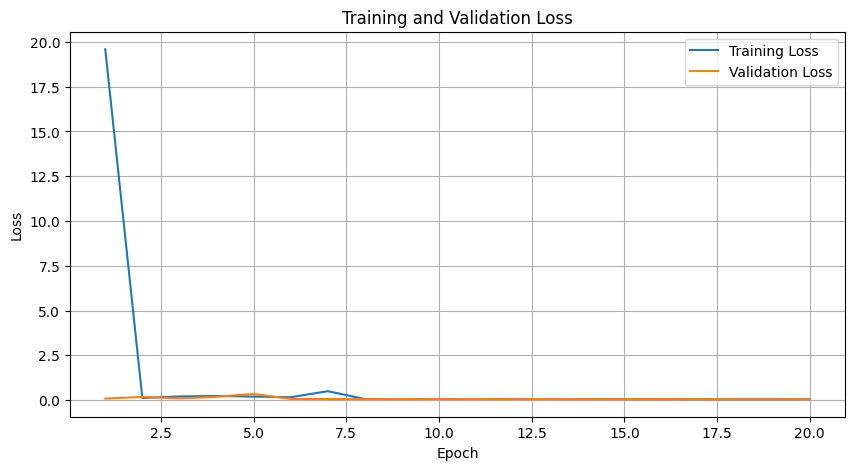

In [7]:
# Plot Loss Curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

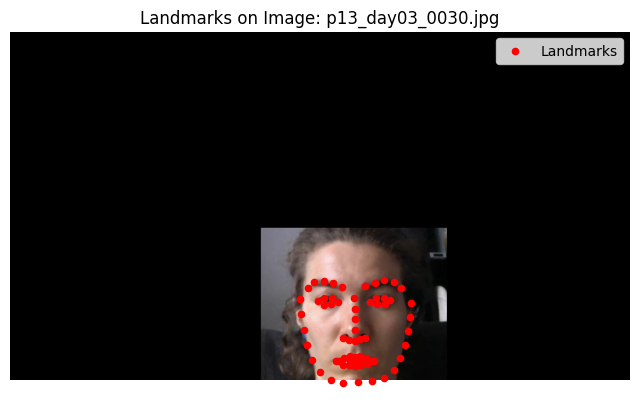

In [8]:
# Visualize Landmarks on a Random Image
import random

def visualize_landmarks(dataset, index=None):
    """
    Visualize landmarks on a random image from the dataset.
    Args:
    - dataset: EyeTrackingDataset object.
    - index: Optional, specify the index of the image. If None, a random index is chosen.
    """
    if index is None:
        index = random.randint(0, len(dataset) - 1)
    
    # Load image and landmarks
    image_path = dataset.samples[index]
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = dataset.detector(gray)
    if len(faces) == 0:
        print(f"No face detected in image: {image_path}")
        return

    landmarks = dataset.predictor(gray, faces[0])
    landmark_coords = np.array([[p.x, p.y] for p in landmarks.parts()], dtype=np.float32)

    # Plot image with landmarks
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.scatter(landmark_coords[:, 0], landmark_coords[:, 1], c="red", s=20, label="Landmarks")
    plt.title(f"Landmarks on Image: {os.path.basename(image_path)}")
    plt.legend()
    plt.axis("off")
    plt.show()

# Visualize landmarks on a random image
visualize_landmarks(dataset)